In [17]:
import numpy as np
import pandas as pd

from environment import EpisodicEnv
from generator import Generator
from propagator import Propagator
from simulator import Simulator
import torch


In [18]:
df_words_similarities = pd.read_csv('data/words_similarities.csv', index_col=0)
df_words_similarities[df_words_similarities < 0] = 0
df_words_similarities[df_words_similarities > 1] = 1

df_locations_similarities = pd.read_csv('data/locations_similarities.csv', index_col=0)
df_locations_similarities[df_locations_similarities < 0] = 0
df_locations_similarities[df_locations_similarities > 1] = 1

df_env_states = pd.read_csv('data/environment_states.csv', index_col=0)
df_env_novel_states = pd.read_csv('data/environment_novel_states.csv', index_col=0)
# Select 5 rows
df_env_novel_states = df_env_novel_states.sample(5)

# Scale time to be between 0 and 1
df_env_states['time'] = df_env_states['time'] / df_env_states['time'].max()

In [19]:
num_states = 50
num_episodes = 50

In [20]:
models = {
    # "standard": (0, 0, 0),
    # "temporal-biased": (0, 1, 0),
    # "spatial-biased": (0, 0, 1),
    "semantic-biased": (10, 0, 0),
    # "semantic-temporal-biased": (1, 1, 0),
    # "semantic-spatial-biased": (1, 0, 1),
    # "temporal-spatial-biased": (0, 1, 1),
    # "semantic-temporal-spatial-biased": (1, 1, 1),
}

data_df = None



for model, params in models.items():
    print(model)
    m, n, o = params

    env = EpisodicEnv(states=df_env_states,
                      semantic_similarities=df_words_similarities,
                      spatial_similarities=df_locations_similarities,
                      k=1, m=m, n=n, o=o)

    env.set_reward(df_env_novel_states)

    generator = Generator(env)
    propagator = Propagator(generator)
    # propagator.min_auto_cf(rho_init=0, maxiter=10)
    simulator = Simulator(propagator)

    rewards_sum = []
    states_array = None
    for _ in range(num_episodes):
        states, log_probs, rewards = simulator.sample_states(num_states=num_states)
        rewards_sum.append(np.array(rewards).sum())

        states_i = [int(s) for s in states]
        states_i = np.array(states_i).astype(int).reshape(1, -1)
        if states_array is None:
            states_array = states_i
        else:
            states_array = np.concatenate([states_array, states_i])

    data_df_i = pd.DataFrame({
        "model": [model] * num_episodes,
        "rewards": rewards_sum
    })
    if data_df is None:
        data_df = data_df_i
    else:
        data_df = pd.concat([data_df, data_df_i])


semantic-biased
['cap', 'chair', 'laptop', 'telephone', 'friend', 'pen', 'bed', 'candles', 'bicycle', 'towel', 'bench', 'cloud', 'cake', 'mirror', 'clothes', 'door', 'sand', 'fan', 'hat', 'field', 'clock', 'backpack', 'water', 'bottle', 'exam', 'speaker', 'kettlebell', 'music', 'kitchen', 'car', 'egg', 'plant', 'tree', 'sunglasses', 'hammer', 'guitar', 'ball', 'wind', 'cat', 'rug', 'path', 'church', 'painting', 'family', 'toaster', 'jacuzzi', 'co-worker', 'fireworks', 'bus', 'table', 'kayak']


/Users/aleix11alcacer/miniconda3/envs/reinforcement-learning/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/aleix11alcacer/miniconda3/envs/reinforcement-learning/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


State distribution must be non-negative, cropping to 0
State distribution must be non-negative, cropping to 0
State distribution must be non-negative, cropping to 0
State distribution must be non-negative, cropping to 0
State distribution must be non-negative, cropping to 0
State distribution must be non-negative, cropping to 0
State distribution must be non-negative, cropping to 0
State distribution must be non-negative, cropping to 0
State distribution must be non-negative, cropping to 0
State distribution must be non-negative, cropping to 0
State distribution must be non-negative, cropping to 0
State distribution must be non-negative, cropping to 0
State distribution must be non-negative, cropping to 0
State distribution must be non-negative, cropping to 0
State distribution must be non-negative, cropping to 0
State distribution must be non-negative, cropping to 0
State distribution must be non-negative, cropping to 0
State distribution must be non-negative, cropping to 0
State dist

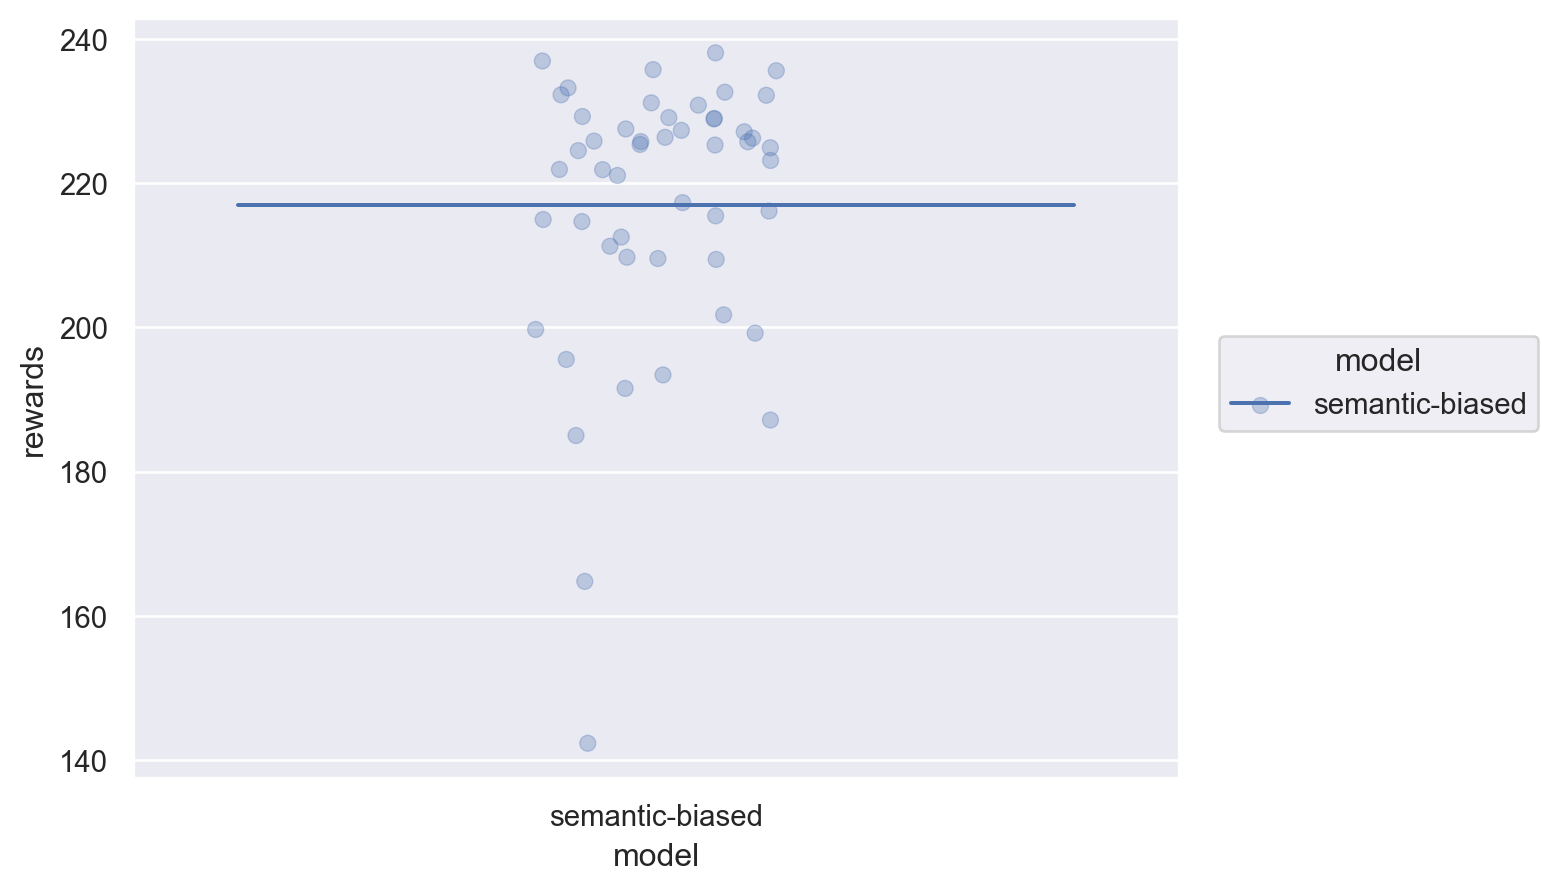

In [21]:
import seaborn.objects as so

(
    so.Plot(data_df, x="model", y="rewards", color="model")
    .add(so.Dot(alpha=0.3), so.Dodge(), so.Jitter(.3))
    .add(so.Dash(), so.Agg(), so.Dodge())
)


In [22]:
from autocorrelation import estimate_acf

states_i = [int(s) for s in states]
states_i = np.array(states_i).astype(int).reshape(1, -1)

acf_mean, acf_sem = estimate_acf(env, states_array.reshape(50, 50, 1))


(50, 50, 1)


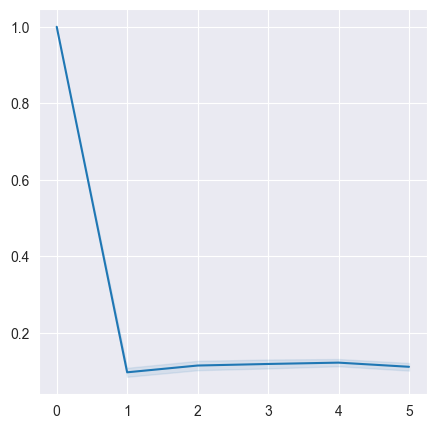

In [23]:
import matplotlib.pyplot as plt

lags = np.arange(0, 6)
ind = 0

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# plot mean
ax.plot(lags, acf_mean[lags, ind], label="Episodic Inference Model", color="C0")
ax.fill_between(lags, acf_mean[lags, ind] - acf_sem[lags, ind], acf_mean[lags, ind] + acf_sem[lags, ind], alpha=0.1, color="C0")

plt.show()

In [24]:
acf_mean

array([[1.        ],
       [0.09649361],
       [0.1142045 ],
       [0.11828362],
       [0.1217752 ],
       [0.11089656],
       [0.10929056],
       [0.08649934],
       [0.11303981],
       [0.11251355],
       [0.08929574],
       [0.09814365],
       [0.08953145],
       [0.11729007],
       [0.09895804],
       [0.09086628],
       [0.10925456],
       [0.07711729],
       [0.1013904 ],
       [0.10332868],
       [0.09476904],
       [0.07813038],
       [0.08592856],
       [0.07802708],
       [0.08988327],
       [0.06846881],
       [0.07848867],
       [0.07858582],
       [0.07956854],
       [0.07471867],
       [0.06760148],
       [0.07751519],
       [0.06605439],
       [0.05527327],
       [0.06999306],
       [0.06323656],
       [0.06279002],
       [0.05597357],
       [0.04313233],
       [0.05837639],
       [0.05415752],
       [0.04256988],
       [0.05250973],
       [0.04118942],
       [0.04952778],
       [0.03906923],
       [0.03061315],
       [0.027